In [1]:
get_ipython().run_line_magic('load_ext', 'autoreload')
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
#export CUDA_VISIBLE_DEVICES='2'
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
from pathlib import Path

2022-05-03 05:07:19.919139: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10052043212056840288
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12389677971728350966
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 640498964794189878
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31597102464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 914083286075721140
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:07.0, compute capability: 7.0"
]


2022-05-03 05:07:21.326177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-03 05:07:21.338367: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200100000 Hz
2022-05-03 05:07:21.341209: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5570afbfd490 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-03 05:07:21.341237: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-03 05:07:21.345079: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-05-03 05:07:21.478882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.

In [2]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = "/home/centos/rabeea/maski/Mask_RCNN-master/"
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib


# In[7]:


# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [3]:
class CocoSynthConfig(Config):
    """Configuration for training on the box_synthetic dataset.
    Derives from the base Config class and overrides specific values.
    """
    # Give the configuration a recognizable name
    NAME = "2d_data"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 2  # background + 7 box types

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 1088 # should be divisible by 2 atleast 6 times
    IMAGE_MAX_DIM = 1088

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 1000

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 10
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
    IMAGE_CHANNEL_COUNT = 3
    
config = CocoSynthConfig()
config.display()


# In[9]:


class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
#         k=0
        missing=[]
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
#             print (class_id, class_name)
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))

                try:
                    image_annotations = annotations[image_id]

                    # Add the image using the base method from utils.Dataset
                    self.add_image(
                        source=source_name,
                        image_id=image_id,
                        path=image_path,
                        width=image_width,
                        height=image_height,
                        annotations=image_annotations
                    )
                except:
                    missing.append(image_id)
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids


# In[10]:




Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1088
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1088
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1088 1088    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
dataset_train = CocoLikeDataset()
dataset_train.load_data("/home/centos/rabeea/maski/paper/mask_rcnn/coco_instances.json",
                        "/home/centos/rabeea/maski/paper/mask_rcnn/images/")
dataset_train.prepare()


In [5]:

dataset_val = CocoLikeDataset()
dataset_val.load_data("/home/centos/rabeea/maski/paper/mask_rcnn/coco_instances.json",
                        "/home/centos/rabeea/maski/paper/mask_rcnn/images/")
dataset_val.prepare()


Displaying examples from training dataset:


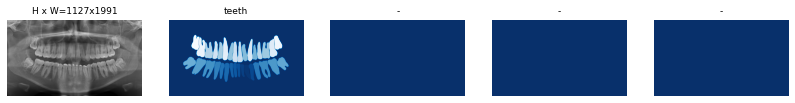

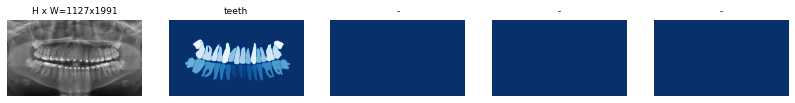

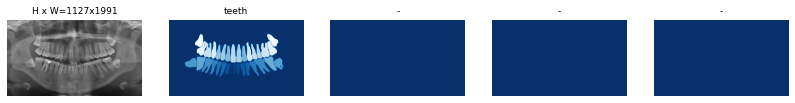

Displaying examples from validation dataset:


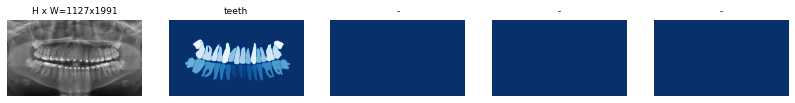

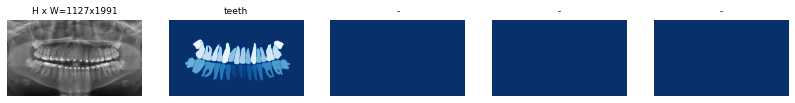

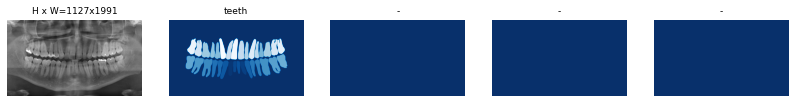

In [6]:
for name, dataset in [('training', dataset_train), ('validation', dataset_val)]:
    print(f'Displaying examples from {name} dataset:')
    
    image_ids = np.random.choice(dataset.image_ids, 3)
    for image_id in image_ids:
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)


In [7]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)



2022-05-03 05:07:43.901374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 05:07:43.902822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:07.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-03 05:07:43.902881: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-05-03 05:07:43.902924: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-05-03 05:07:43.902941: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-05-03 05:07:43.902958: I tensorflow/stream_executor/plat

In [8]:
# Which weights to start with?
init_with ="coco" #"imagenet"# "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["conv1","mrcnn_class_logits", "mrcnn_bbox_fc", 
                                  "mrcnn_bbox", "mrcnn_mask"])
#     model.load_weights(COCO_MODEL_PATH, by_name=True,
#                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#                                 "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)


# In[15]:


2022-05-03 05:08:06.326513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 05:08:06.327984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:07.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-03 05:08:06.328051: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-05-03 05:08:06.328100: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-05-03 05:08:06.328118: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-05-03 05:08:06.328136: I tensorflow/stream_executor/plat

In [9]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/centos/rabeea/maski/Mask_RCNN-master/logs/2d_data20220503T0508/mask_rcnn_2d_data_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed

/home/centos/anaconda3/envs/beea38/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
2022-05-03 05:08:43.780464: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-05-03 05:08:44.025660: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


   1/1000 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 8.0109 - rpn_class_loss: 1.0287 - rpn_bbox_loss: 3.7565 - mrcnn_class_loss: 0.6341 - mrcnn_bbox_loss: 1.2823 - mrcnn_mask_loss: 1.3093

2022-05-03 05:08:47.625666: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-05-03 05:08:47.625803: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 1 GPUs
2022-05-03 05:08:47.626245: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcupti.so.10.1'; dlerror: libcupti.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64
2022-05-03 05:08:47.627674: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcupti.so


   3/1000 [..............................] - ETA: 7:32 - batch: 1.0000 - size: 1.0000 - loss: 6.7196 - rpn_class_loss: 0.9343 - rpn_bbox_loss: 3.1690 - mrcnn_class_loss: 0.5874 - mrcnn_bbox_loss: 0.9752 - mrcnn_mask_loss: 1.0537 

2022-05-03 05:08:48.470759: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-05-03 05:08:48.496213: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 2335 callback api events and 2335 activity events. 
2022-05-03 05:08:48.650849: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: /home/centos/rabeea/maski/Mask_RCNN-master/logs/2d_data20220503T0508/plugins/profile/2022_05_03_05_08_48
2022-05-03 05:08:48.707113: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to /home/centos/rabeea/maski/Mask_RCNN-master/logs/2d_data20220503T0508/plugins/profile/2022_05_03_05_08_48/nipa2019-0105.trace.json.gz
2022-05-03 05:08:48.815531: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: /home/centos/rabeea/maski/Mask_RCNN-master/logs/2d_data20220503T0508/plugins/profile/2022_05_03_05_08_48
2022-05-03 05:08:48.824

1000/1000 [==============================] - ETA: 0s - batch: 499.5000 - size: 1.0000 - loss: 1.1790 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.4395 - mrcnn_class_loss: 0.2126 - mrcnn_bbox_loss: 0.2335 - mrcnn_mask_loss: 0.2726WARNING:tensorflow:From /home/centos/anaconda3/envs/beea38/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
1000/1000 [==============================] - 1943s 2s/step - batch: 499.5000 - size: 1.0000 - loss: 1.1790 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.4395 - mrcnn_class_loss: 0.2126 - mrcnn_bbox_loss: 0.2335 - mrcnn_mask_loss: 0.2726 - val_loss: 0.6147 - val_rpn_class_loss: 0.0066 - val_rpn_bbox_loss: 0.1860 - val_mrcnn_class_loss: 0.1092 - val_mrcnn_bbox_loss: 0.1103 - val_mrcnn_mask_loss:

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=100, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


# In[15]:




Starting at epoch 5. LR=0.0001

Checkpoint Path: /home/centos/rabeea/maski/Mask_RCNN-master/logs/2d_data20220503T0508/mask_rcnn_2d_data_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b    

2022-05-03 07:49:59.745502: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


   3/1000 [..............................] - ETA: 8:09 - batch: 1.0000 - size: 1.0000 - loss: 0.3078 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0975 

2022-05-03 07:49:59.982798: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-05-03 07:50:00.043663: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 5788 callback api events and 5788 activity events. 
2022-05-03 07:50:00.510622: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: /home/centos/rabeea/maski/Mask_RCNN-master/logs/2d_data20220503T0508/plugins/profile/2022_05_03_07_50_00
2022-05-03 07:50:00.661221: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to /home/centos/rabeea/maski/Mask_RCNN-master/logs/2d_data20220503T0508/plugins/profile/2022_05_03_07_50_00/nipa2019-0105.trace.json.gz
2022-05-03 07:50:00.933957: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: /home/centos/rabeea/maski/Mask_RCNN-master/logs/2d_data20220503T0508/plugins/profile/2022_05_03_07_50_00
2022-05-03 07:50:00.943

1000/1000 [==============================] - 1940s 2s/step - batch: 499.5000 - size: 1.0000 - loss: 0.5033 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.1120 - val_loss: 0.3844 - val_rpn_class_loss: 0.0023 - val_rpn_bbox_loss: 0.0101 - val_mrcnn_class_loss: 0.0637 - val_mrcnn_bbox_loss: 0.0226 - val_mrcnn_mask_loss: 0.0936
Epoch 7/100
1000/1000 [==============================] - 1907s 2s/step - batch: 499.5000 - size: 1.0000 - loss: 0.3963 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.1008 - val_loss: 0.3919 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 0.0148 - val_mrcnn_class_loss: 0.0622 - val_mrcnn_bbox_loss: 0.0168 - val_mrcnn_mask_loss: 0.0989
Epoch 8/100
1000/1000 [==============================] - 1924s 2s/step - batch: 499.5000 - size: 1.0000 - loss: 0.3355 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0089 - mrcnn_class_lo

In [11]:
class InferenceConfig(CocoSynthConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 1088
    IMAGE_MAX_DIM = 1088
    DETECTION_MIN_CONFIDENCE = 0.85
    


In [24]:

inference_config = InferenceConfig()


# In[16]:


# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)


# In[17]:


# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = str(Path(ROOT_DIR) / "logs" / "2d_data20220503T0508/mask_rcnn_2d_data_0001.h5" )
# model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


# In[ ]:



Loading weights from  /home/centos/rabeea/maski/Mask_RCNN-master/logs/2d_data20220503T0508/mask_rcnn_2d_data_0001.h5
Re-starting from epoch 1


Processing 1 images
image                    shape: (1127, 1991, 3)       min:   16.00000  max:  237.00000  uint8
molded_images            shape: (1, 1088, 1088, 3)    min: -123.70000  max:  130.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1991.00000  float64
anchors                  shape: (1, 295647, 4)        min:   -0.08327  max:    1.02439  float32


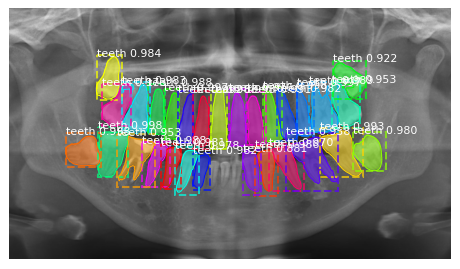

Processing 1 images
image                    shape: (1127, 1991, 3)       min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 1088, 1088, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1991.00000  float64
anchors                  shape: (1, 295647, 4)        min:   -0.08327  max:    1.02439  float32


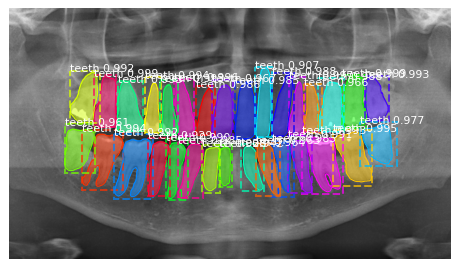

Processing 1 images
image                    shape: (1127, 1991, 3)       min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 1088, 1088, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1991.00000  float64
anchors                  shape: (1, 295647, 4)        min:   -0.08327  max:    1.02439  float32


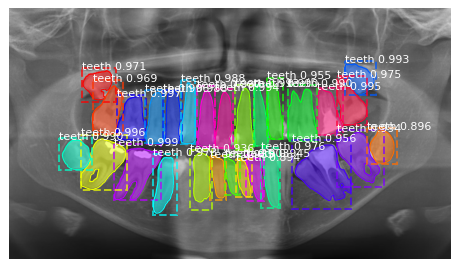

Processing 1 images
image                    shape: (1127, 1991, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1088, 1088, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1991.00000  float64
anchors                  shape: (1, 295647, 4)        min:   -0.08327  max:    1.02439  float32


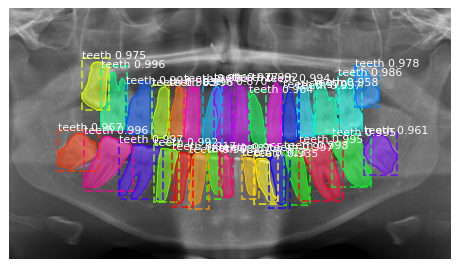

Processing 1 images
image                    shape: (1127, 1991, 3)       min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 1088, 1088, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1991.00000  float64
anchors                  shape: (1, 295647, 4)        min:   -0.08327  max:    1.02439  float32


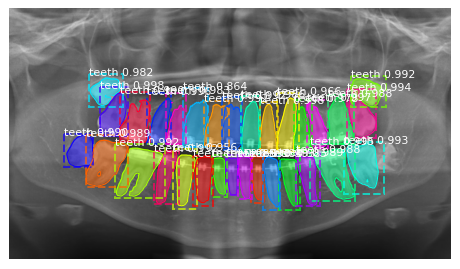

Processing 1 images
image                    shape: (1127, 1991, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1088, 1088, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1991.00000  float64
anchors                  shape: (1, 295647, 4)        min:   -0.08327  max:    1.02439  float32


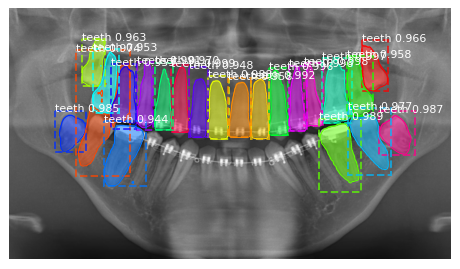

In [25]:


import skimage

real_test_dir = "/home/centos/rabeea/maski/paper/mask_rcnn/images/"
ff= os.listdir(real_test_dir)
image_paths = []
for filename in ff:
    image_paths.append(os.path.join(real_test_dir, filename))
k=0
for image_path in image_paths:
    img = skimage.io.imread(image_path)

    results = model.detect([img], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names, r['scores'], figsize=(8,8))
    k=k+1


In [20]:
%load_ext tensorboard

In [24]:
get_ipython().run_line_magic('tensorboard', '--logdir logs')

Reusing TensorBoard on port 6006 (pid 87246), started 1:29:36 ago. (Use '!kill 87246' to kill it.)

In [27]:
!pwd

/home/centos/rabeea/maski/dataset and code/src


In [26]:
!conda env export > mask_rcnn.yml